In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [4]:
df = pd.read_csv("../2_Feature_Extraction/extract_features/tracking_features.csv")
df.head()


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops
0,59,72,0.001813,39681.685256,104.093826,72
1,65,154,0.006207,24806.119875,103.039632,154
2,78,237,0.046257,5123.419281,153.782723,237
3,87,14,0.002002,6988.110554,508.602238,14
4,172,253,0.000831,304095.272770,50.290536,253


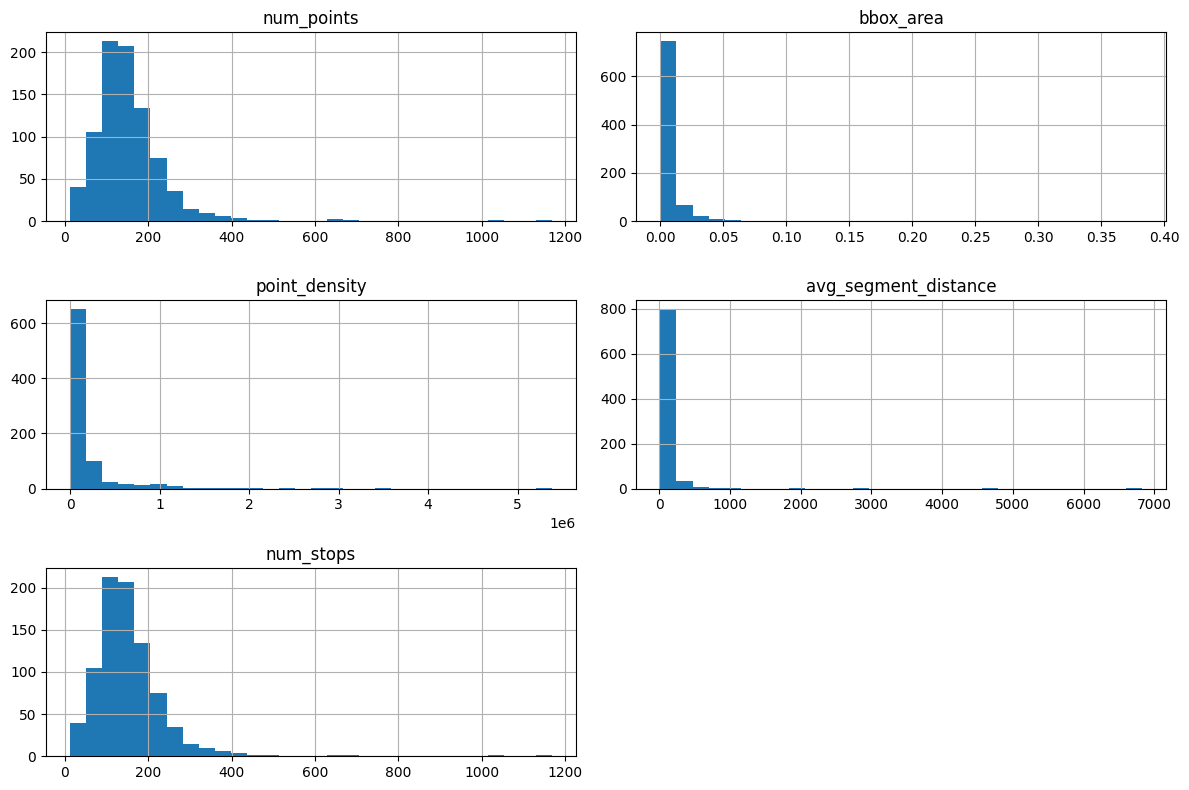

In [5]:
df.drop(columns=["tracking_id"]).hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


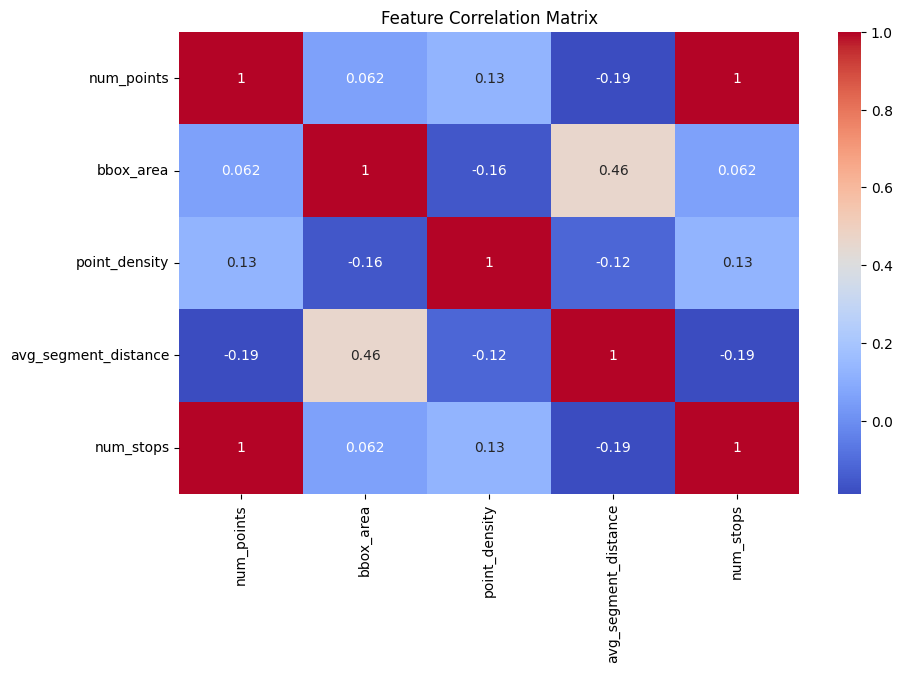

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=["tracking_id"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
X = df.drop(columns=["tracking_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

df.head()


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,cluster
0,59,72,0.001813,39681.685256,104.093826,72,1
1,65,154,0.006207,24806.119875,103.039632,154,1
2,78,237,0.046257,5123.419281,153.782723,237,0
3,87,14,0.002002,6988.110554,508.602238,14,1
4,172,253,0.000831,304095.272770,50.290536,253,0


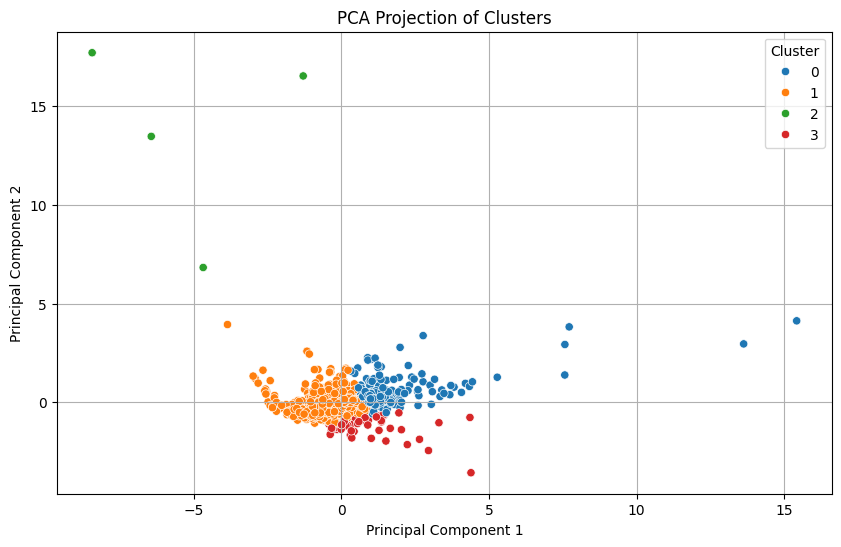

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("PCA Projection of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()


In [10]:
# Summarize feature means by cluster
summary = df.groupby("cluster").mean(numeric_only=True)
summary["count"] = df["cluster"].value_counts().sort_index()
summary


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,pca1,pca2,count
cluster,,,,,,,,,
0,51355.854430,273.778481,0.009343,1.294882e+05,89.305038,273.778481,1.823415,0.600236,158
1,45835.758998,122.544601,0.005217,1.022906e+05,133.425675,122.544601,-0.488519,-0.138283,639
2,19805.750000,61.250000,0.181118,2.526781e+02,3677.601336,61.250000,-5.211021,13.636301,4
3,53136.122449,166.510204,0.000132,1.434423e+06,42.481586,166.510204,0.916498,-1.245304,49


In [17]:
N = 2
example_ids = df.groupby("cluster")["tracking_id"].apply(lambda x: x.sample(min(N, len(x)), random_state=42)).explode().tolist()

waypoints = pd.read_parquet("../2_Feature_Extraction/data/filtered_waypoints.parquet")

example_routes = waypoints[waypoints["id_tracking"].isin(example_ids)].copy()


In [ ]:
import folium
from folium import Map, PolyLine
from IPython.display import display

cluster_colors = ["blue", "orange", "green", "red"]

for tracking_id in example_ids:
    route = example_routes[example_routes["id_tracking"] == tracking_id].sort_values(by="sequence")
    coords = list(zip(route["latitude"], route["longitude"]))
    cluster_label = df[df["tracking_id"] == tracking_id]["cluster"].values[0]
    
    m = folium.Map(location=coords[0], zoom_start=13)
    folium.PolyLine(coords, color=cluster_colors[cluster_label], weight=5).add_to(m)
    folium.Marker(coords[0], tooltip=f"Tracking {tracking_id} - Cluster {cluster_label}").add_to(m)
    display(m)


In [20]:
# manually assign labels to clusters depending on point density because it is a good factor as determined in the data analysis

cluster_to_label = {
    0: "SUBURBAN", 
    1: "TOWN",
    2: "RURAL",
    3: "URBAN"
}

df["predicted_label"] = df["cluster"].map(cluster_to_label)
df.to_csv("tracking_features_with_labels.csv", index=False)
print("saved predicted labels to csv")


saved predicted labels to csv
